# SEM 2D BSE Imaging: Fe AstroEBSD example

This is a template file to demonstrate angle resolved BSE imaging via signal extraction from raw, saved, EBSD patterns.

A key advantage when using saved raw EBSD patterns is that we can partition the raw signal into a "Kikuchi pattern" and a "background" signal, which will give different types of contrasts. This partition is impossible when using conventional semiconductor diode detection etc. for angle-resolved signal BSE collection. We cannot distinguish between "Kikuchi signal" and "background signal" in the current from the diode (point-signal, 0D as compared to 2D signal on the phosphor screen).

Here, we use the AstroEBSD example data set from Ben Britton, which is publicly available as a HDF5 file from https://doi.org/10.5281/zenodo.1214828

In [1]:
# directory with the HDF5 EBSD pattern file:
data_dir = "../../../xcdskd_reference_data/Ben_Astro/"

# filename of the HDF5 file:
hdf5_filename =  "Demo_Ben.h5"

# verbose output
output_verbose = False

Necessary packages

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# ignore divide by Zero
np.seterr(divide='ignore', invalid='ignore')

import time, sys, os
import h5py
import skimage.io 

from aloe.plots import normalizeChannel, make2Dmap, get_vrange
from aloe.plots import plot_image, plot_SEM, plot_SEM_RGB
from aloe.image import arbse
from aloe.image.downsample import downsample
from aloe.image.kikufilter import process_ebsp

In [3]:
# make result dirs and filenames
h5FileNameFull=os.path.abspath(data_dir + hdf5_filename)
h5FileName, h5FileExt = os.path.splitext(h5FileNameFull)
h5FilePath, h5File = os.path.split(h5FileNameFull)
timestr = time.strftime("%Y%m%d-%H%M%S")
h5ResultFile="arBSE_" + hdf5_filename
    

# close HDF5 file if still open
if 'f' in locals():
    f.close()    
f=h5py.File(h5FileName+h5FileExt, "r")

ResultsDir = h5FilePath+"/arBSE_" + timestr + "/" 
CurrentDir = os.getcwd()
#print('Current Directory: '+CurrentDir)
#print('Results Directory: '+ResultsDir)
if not os.path.isdir(ResultsDir):
    os.makedirs(ResultsDir)
os.chdir(ResultsDir)

if output_verbose:
    print('HDF5 full file name: ', h5FileNameFull)
    print('HDF5 File: ', h5FileName+h5FileExt)
    print('HDF5 Path: ', h5FilePath)
    print('Results Directory: ', ResultsDir)
    print('Results File: ', h5ResultFile)

In [4]:
DataGroup="/Demo_Ben/EBSD/Data/"
HeaderGroup="/Demo_Ben/EBSD/Header/"
Patterns = f[DataGroup+"RawPatterns"]
#StaticBackground=f[DataGroup+"StaticBackground"]
XIndex =   f[DataGroup+"X BEAM"]
YIndex =   f[DataGroup+"Y BEAM"]
MapWidth = f[HeaderGroup+"NCOLS"].value
MapHeight= f[HeaderGroup+"NROWS"].value
PatternHeight=f[HeaderGroup+"PatternHeight"].value
PatternWidth =f[HeaderGroup+"PatternWidth"].value
print('Pattern Height: ', PatternHeight)
print('Pattern Width : ', PatternWidth)
PatternAspect=float(PatternWidth)/float(PatternHeight)
print('Pattern Aspect: '+str(PatternAspect))
print('Map Height: ', MapHeight)
print('Map Width : ', MapWidth)

step_map_microns = f[HeaderGroup+"XSTEP"].value
print('Map Step Size (microns): ', step_map_microns)

Pattern Height:  1200
Pattern Width :  1600
Pattern Aspect: 1.3333333333333333
Map Height:  83
Map Width :  110
Map Step Size (microns):  0.1497860178


Check Optional Pattern Processing

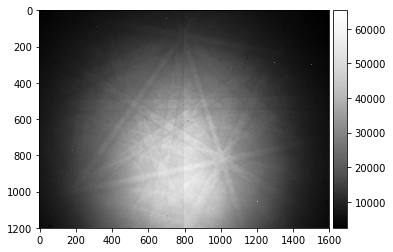

In [5]:
ipattern = 215
raw_pattern=Patterns[ipattern,:,:]
plot_image(raw_pattern)
skimage.io.imsave('pattern_raw_' + str(ipattern) + '.tiff', raw_pattern, plugin='tifffile')

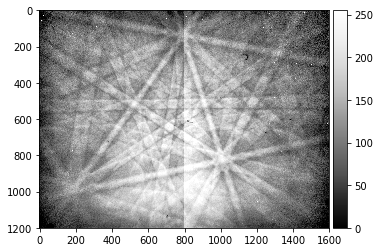

In [6]:
# note the CCD halves and static background dust, hot pixels
processed_pattern = process_ebsp(raw_pattern, binning=1)
plot_image(processed_pattern)
skimage.io.imsave('pattern_processed_' + str(ipattern) + '.tiff', processed_pattern, plugin='tifffile')

In [7]:
background_static = np.loadtxt(data_dir + "background_static.txt")

Making a static background from the EBSD map itself (can be useful with polycrystalline samples): 

In [8]:
calc_bg = False
if calc_bg:
    # avoid loading 35GB into RAM if you don't have 35GB RAM...
    # use incremental "updating average"
    # https://math.stackexchange.com/questions/106700/incremental-averageing
    tstart = time.time()
    npatterns = Patterns.shape[0]
    current_average = np.copy(Patterns[0]).astype(np.float64)
    for i in range(1, npatterns):
        current_average = current_average + (Patterns[i] - current_average)/i
        # update time info every 100 patterns
        if (i % 100 == 0):
            progress=100.0*(i+1)/Patterns.shape[0]
            tup = time.time()
            togo = (100.0-progress)*(tup-tstart)/(60.0*progress)
            sys.stdout.write("\rtotal map points:%5i current:%5i progress: %4.2f%% -> %6.1f min to go" % (Patterns.shape[0],i+1,progress,togo))
            sys.stdout.flush()

    background_static = current_average

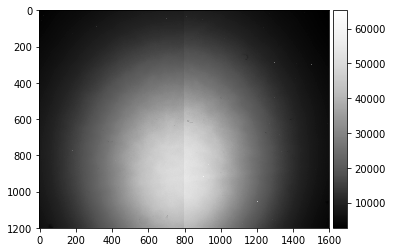

In [9]:
plot_image(background_static)
#skimage.io.imsave('background_static.tiff', background_static, plugin='tifffile') # this is 16bit only
np.savetxt('background_static.txt', background_static)

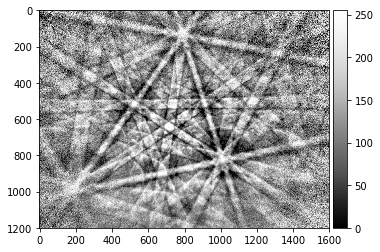

In [10]:
# note the CCD halves and static background dust, hot pixels
processed_pattern = process_ebsp(raw_pattern, static_background=background_static, binning=1)
plot_image(processed_pattern)
skimage.io.imsave('pattern_processed_static_' + str(ipattern) + '.tiff', processed_pattern, plugin='tifffile')

Specification of Image Pre-Processing Functions

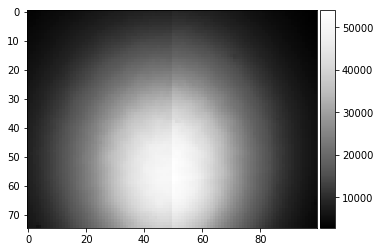

(75, 100)


In [11]:
prebinning=16
background_static_binned = downsample(background_static, prebinning)

def pipeline_process(pattern, prebinning=1, kikuchi=False):
    if prebinning>1:
        pattern = downsample(pattern, prebinning)
    if kikuchi:
        return process_ebsp(pattern, static_background=background_static_binned, binning=1)
    else:
        return pattern
    
def process_kikuchi(pattern):
    return pipeline_process(pattern, prebinning=prebinning, kikuchi=True)

def process_bin(pattern):
    return pipeline_process(pattern, prebinning=prebinning, kikuchi=False)

plot_image(background_static_binned)
print(background_static_binned.shape)

##  vBSE Array

We convert the raw pattern into a 7x7 array of vBSE sensor intensities.

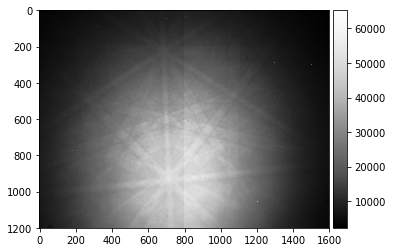

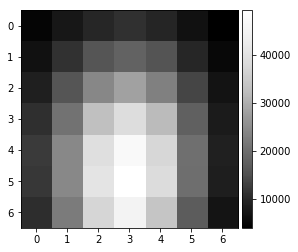

In [12]:
pattern = pipeline_process(Patterns[1000], kikuchi=False)
vbse = arbse.rebin_array(pattern)
plot_image(pattern)
plot_image(vbse)

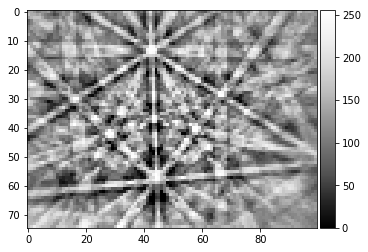

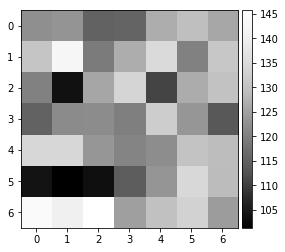

In [13]:
pattern = process_kikuchi(Patterns[1000])
vkiku = arbse.rebin_array(pattern)
plot_image(pattern)
plot_image(vkiku)

## vBSE Detector Signals: Calculation & Saving

This should take a few minutes, depending on your computer and file access speed.

### Virtual BSE Imaging

Imaging the raw intensity in the respective area of the 2D detector (e.g. phosphor screen). Neglects gnomonic projection effect on intensities.

In [14]:
# calculate the vBSE signals in 7x7 array
vbse_array = arbse.make_vbse_array(Patterns)

# make vBSE map of the total screen intensity
bse_total = np.sum(np.sum(vbse_array[:,:,:], axis=1), axis=1)
bse_map = make2Dmap(bse_total, XIndex, YIndex, MapHeight, MapWidth)

total points: 9130 current: 9130 finished -> total calculation time :    5.4 min 


In [15]:
# save the results in an extra hdf5 
print()
print(h5ResultFile)
try:
    h5f = h5py.File(h5ResultFile, 'a')
    h5f.create_dataset('vbse', data=vbse_array)
    h5f.create_dataset('/maps/bse_total', data=bse_map)
finally:
    h5f.close()


arBSE_Demo_Ben.h5


### Virtual Orientation Imaging via Kikuchi Pattern Signals

If we process the raw images to obtain only the Kikuchi pattern, we have a modified 2D intensity which can be expected to show increased sensitivity to orientation effects (i.e. changes related to the Kikuchi bands). In a more advanced approach, we could select, for example, specific Kikuchi bands or zone axes to extract imaging signals.

In [16]:
# calculate the vKikuchi signals from processed raw data
vkiku_array = arbse.make_vbse_array(Patterns, process=process_kikuchi)

# make vBSE map of the total screen intensity
kiku_total = np.sum(np.sum(vkiku_array[:,:,:], axis=1), axis=1)
kiku_map = make2Dmap(kiku_total, XIndex, YIndex, MapHeight, MapWidth)

total points: 9130 current: 9130 finished -> total calculation time :    5.1 min 


In [17]:
# save the results in an extra hdf5 
print()
print(h5ResultFile)
try:
    h5f = h5py.File(h5ResultFile, 'a')
    h5f.create_dataset('vkiku', data=vkiku_array)
    h5f.create_dataset('/maps/kiku_total', data=kiku_map)
finally:
    h5f.close()


arBSE_Demo_Ben.h5


## vBSE Signals: Plotting

In [18]:
# plot from HDF5 results
h5f = h5py.File(h5ResultFile, 'r')
vFSD= h5f['vbse']
bse = h5f['/maps/bse_total']
kiku = h5f['/maps/kiku_total']

### Total Signal on Screen

Total sum of the 7x7 arrays, for the raw pattern and the Kikuchi pattern at each map point:

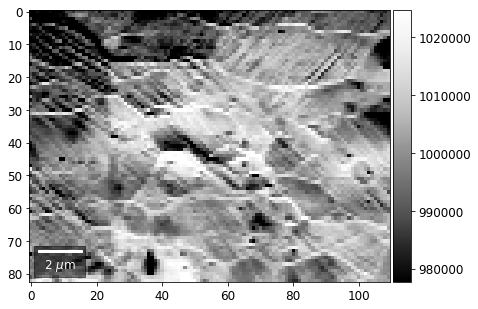

In [19]:
plot_SEM(bse, cmap='Greys_r', microns=step_map_microns)

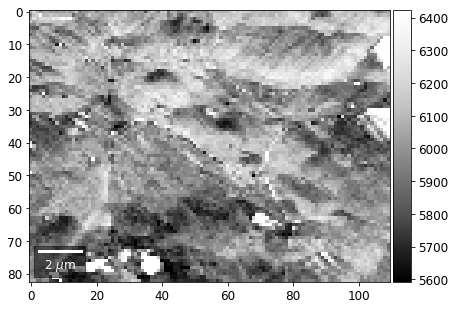

In [20]:
plot_SEM(kiku, cmap='Greys_r', microns=step_map_microns)

### Intensity in Rows and Columns of the vBSE array

We can calculate additional images from the vBSE data set of 7x7 ROIs derived from the original patterns.
As a first example, we plot the intensities of each of the 7 rows and then of each of the 7 columns: 

#### Rows

Range of Values:  [50122.067973821489, 212743.65306487455]


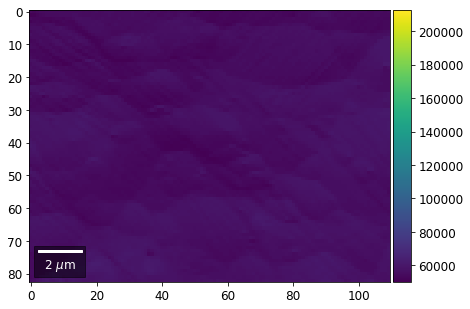

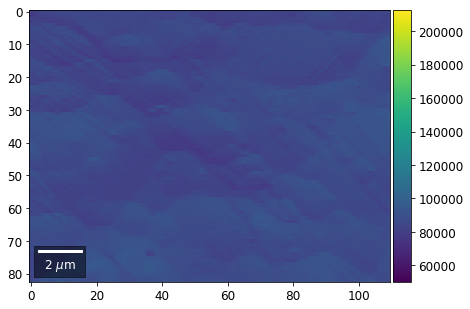

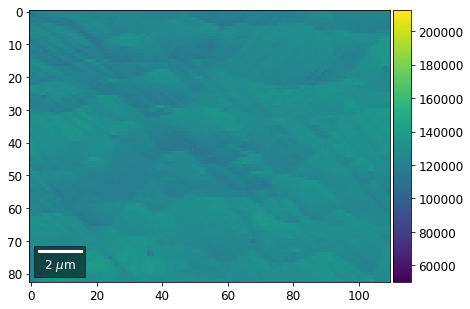

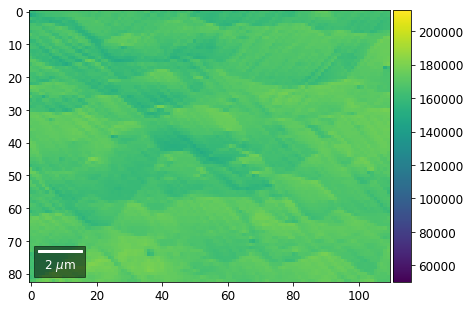

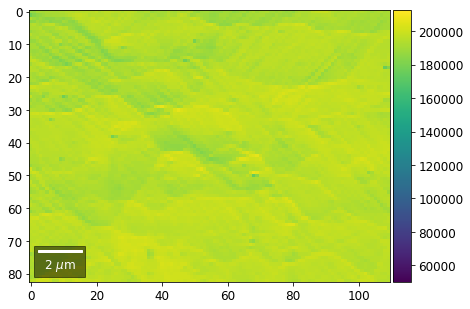

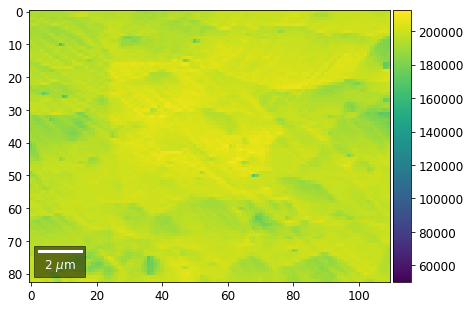

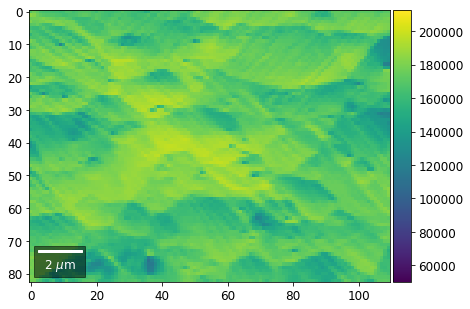

In [21]:
# signal: sum of row 
vmin=40000000
vmax=0

bse_rows = []

# (1) get full range for all images
for row in range(7):
    signal = np.sum(vFSD[:,row,:], axis=1) #/vFSD[:,row+drow,0]
    signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
    minv, maxv = get_vrange(signal, stretch=3.0)
    if (minv<vmin):
        vmin=minv
    if (maxv>vmax):
        vmax=maxv    

# (2) make plots with same range for comparisons of absolute BSE values
vrange=[vmin, vmax]
print('Range of Values: ', vrange)
#vrange=None
for row in range(7):
    signal = np.sum(vFSD[:,row,:], axis=1) #/vFSD[:,row+drow,0]
    signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
    bse_rows.append(signal_map)
    plot_SEM(signal_map, vrange=vrange, filename='vFSD_row_absolute_'+str(row),
             rot180=True, microns=step_map_microns)

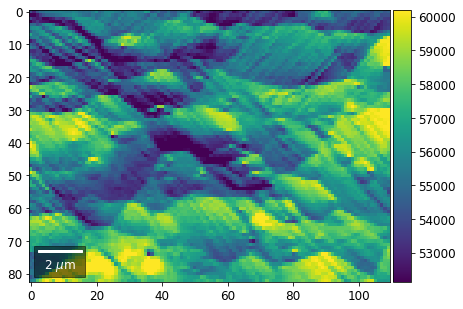

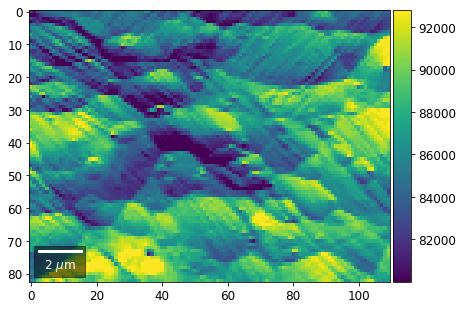

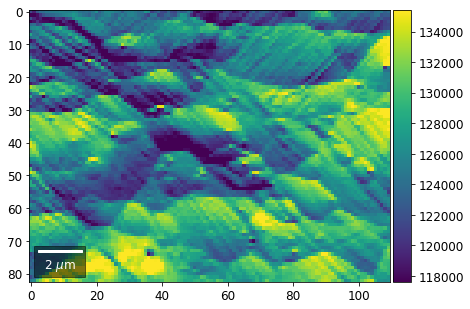

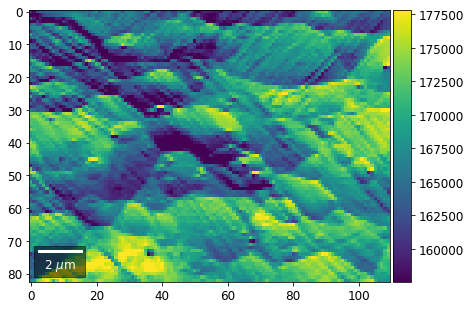

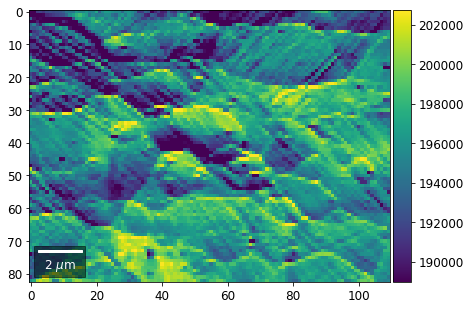

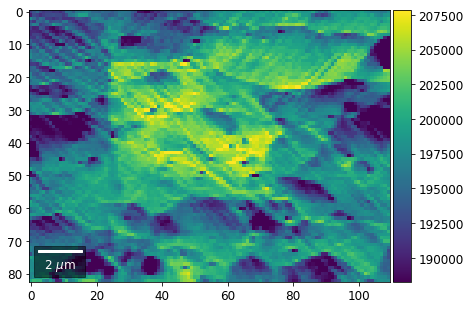

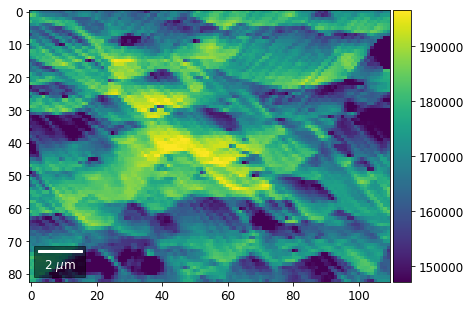

In [22]:
# (3) make plots with  individual ranges for better contrast
vrange=None
for row in range(7):
    signal = np.sum(vFSD[:,row,:], axis=1) #/vFSD[:,row+drow,0]
    signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
    bse_rows.append(signal_map)
    plot_SEM(signal_map, vrange=vrange, filename='vFSD_row_individual_'+str(row),
             rot180=True, microns=step_map_microns)

#### Columns

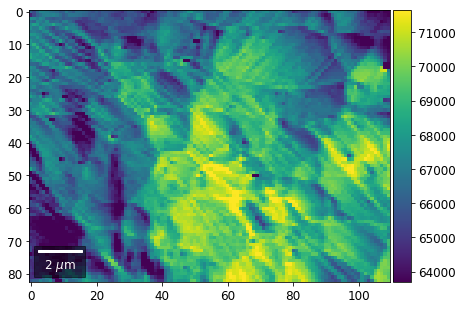

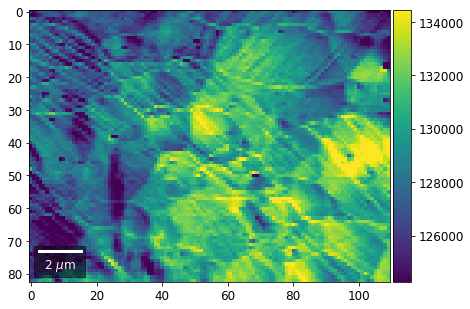

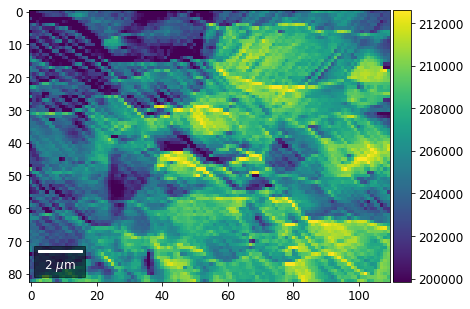

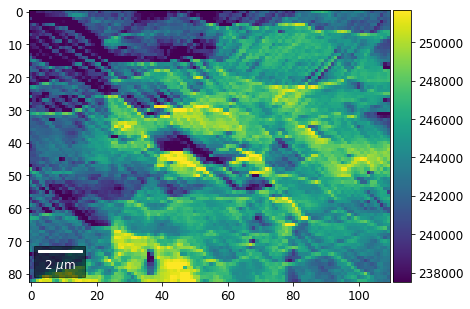

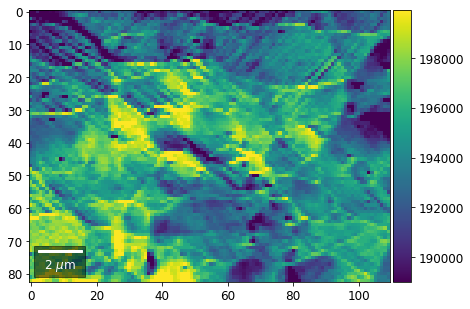

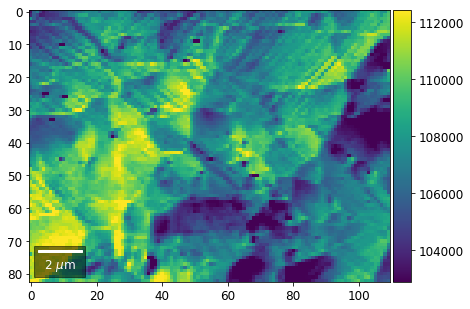

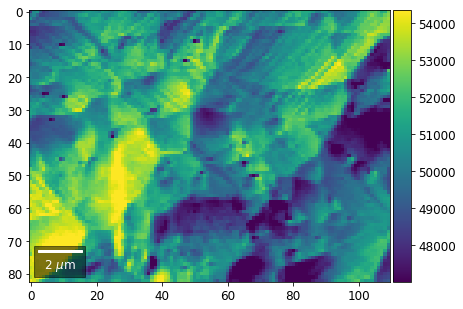

In [23]:
# signal: sum of column
vmin=400000
vmax=0

bse_cols = []

# (1) get full range for all images
for col in range(7):
    signal = np.sum(vFSD[:,:,col], axis=1) #/vFSD[:,row+drow,0]
    signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
    minv, maxv = get_vrange(signal)
    if (minv<vmin):
        vmin=minv
    if (maxv>vmax):
        vmax=maxv    

# (2) make plots with same range for comparisons of absolute BSE values
#vrange=[vmin, vmax]
vrange=None # no fixed scale
for col in range(7):
    signal = np.sum(vFSD[:,:,col], axis=1) #/vFSD[:,row+drow,0]
    signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
    bse_cols.append(signal_map)
    plot_SEM(signal_map, vrange=vrange, filename='vFSD_col_'+str(col),
             rot180=True, microns=step_map_microns)

### vBSE Color Imaging

We can also form color images by assigning red, green, and blue channels to the left, middle, and right vBSE sensors of a row: 

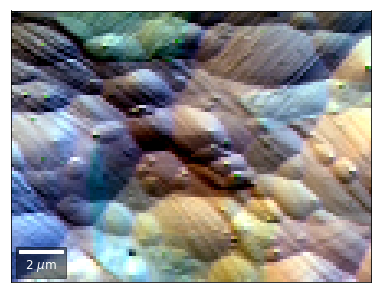

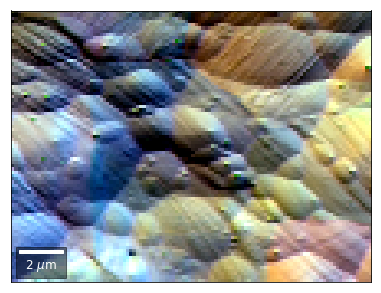

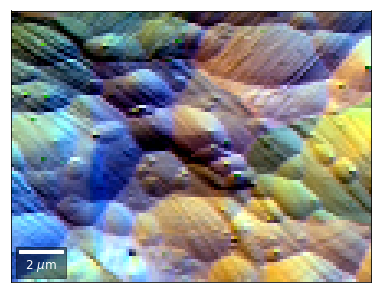

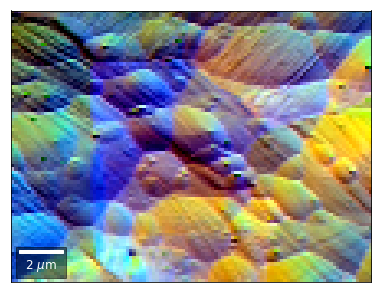

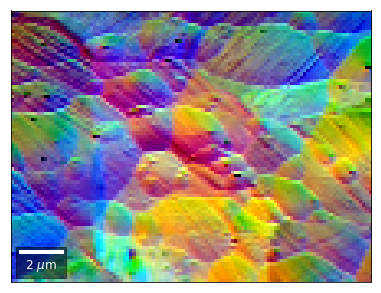

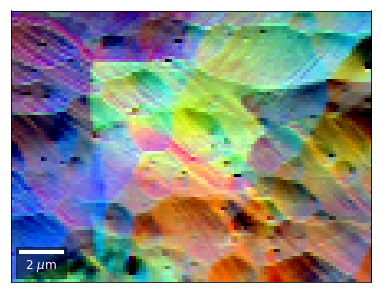

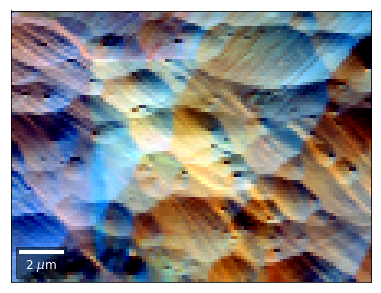

In [24]:
# rgb direct
rgb_direct = []

for row in range(7):
    signal = vFSD[:,row,0]
    red = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    signal = vFSD[:,row,3]
    green = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    signal = vFSD[:,row,6]
    blue = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    rgb=plot_SEM_RGB(red, green, blue, MapHeight, MapWidth, 
                     filename='vFSD_RGB_row_'+str(row),
                     rot180=False, microns=step_map_microns,
                     add_bright=0, contrast=0.8)
    
    rgb_direct.append(rgb)

Differential color signals can be formed by calculating the relative changes to the ROI in the previous row:

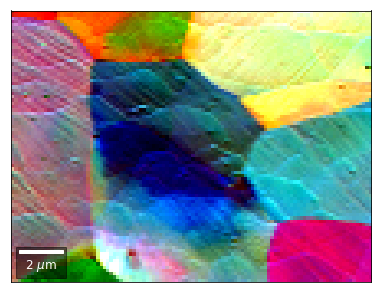

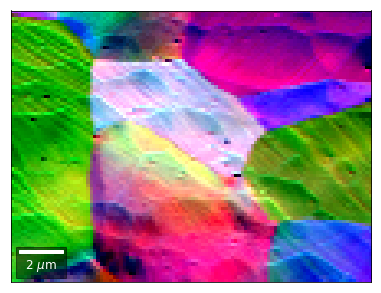

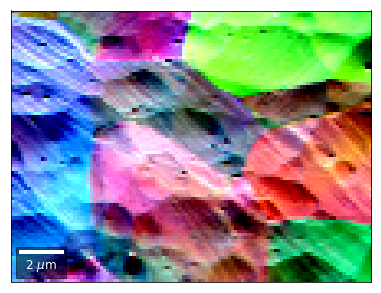

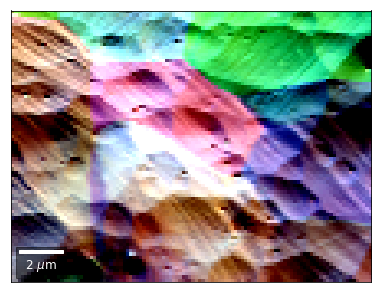

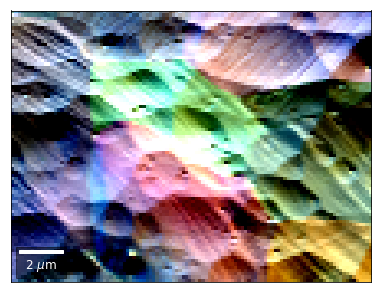

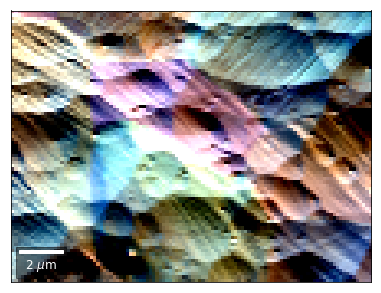

In [25]:
# relative change to previous row
for row in range(1,7):
    drow = -1
    signal = vFSD[:,row,0]/vFSD[:,row+drow,0]
    red = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    signal = vFSD[:,row,2]/vFSD[:,row+drow,2]
    green = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    signal = vFSD[:,row,4]/vFSD[:,row+drow,4]
    blue = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    rgb=plot_SEM_RGB(red, green, blue, MapHeight, MapWidth, 
                     filename='vFSD_RGB_drow_'+str(row),
                     microns=step_map_microns,
                     rot180=False, add_bright=0, contrast=1.2)

The normalized asymmetry between complete consecutive rows: 

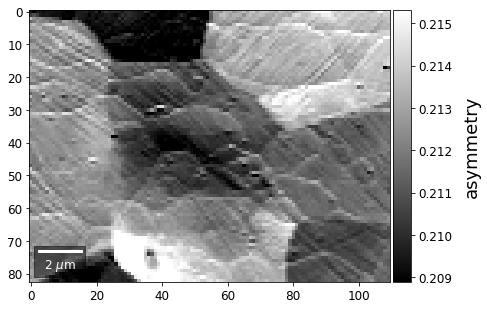

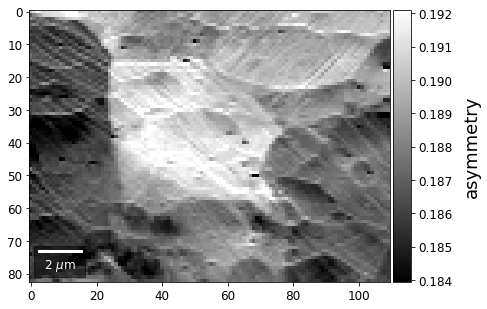

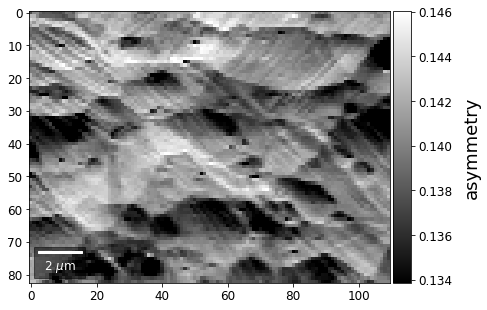

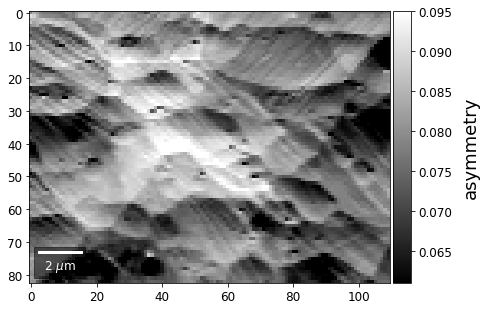

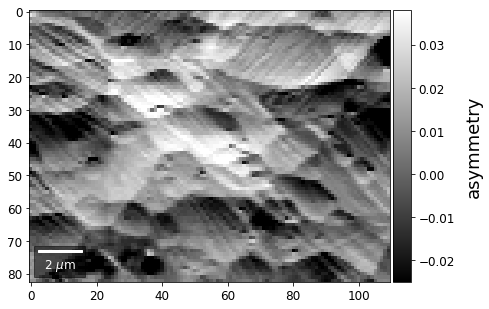

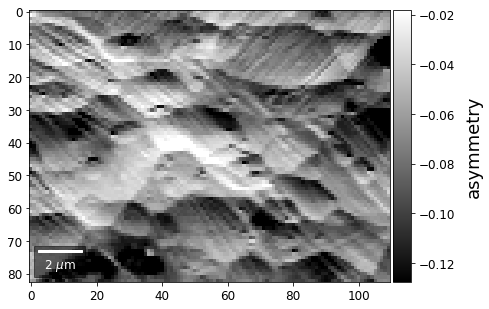

In [26]:
# signal:asymmetry to previous row 
for row in range(1,7):
    drow=-1
    signal = arbse.asy(np.sum(vFSD[:,row,:], axis=1) , np.sum(vFSD[:,row+drow,:], axis=1))
    signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
    plot_SEM(signal_map, vrange=None, cmap='gray', 
             colorbarlabel='asymmetry', microns=step_map_microns,
             filename='vFSD_row_asy_'+str(row))

In [27]:
h5f.close()

## Center of Mass Imaging 

We can interpret the 2D image intensity as a mass density on a plane. The statistical moments of the density distribution (mean, variance, ...) can be used as signal sources. 
In the example below, we use the image center of mass as a signal source.

### COM of Raw Patterns

In [28]:
# calculate the center-of-mass for each pattern, use binning for speed
COMxp, COMyp = arbse.calc_COM_px(Patterns, process=process_bin)

total points: 9130 current: 9130 finished -> total calculation time :    5.1 min 


In [29]:
# save the results in an extra hdf5 
print()
print(h5ResultFile)
try:
    h5f = h5py.File(h5ResultFile, 'a')
    h5f.create_dataset('/COM/COMxp_vbse', data=COMxp)
    h5f.create_dataset('/COM/COMyp_vbse', data=COMyp)    
finally:
    h5f.close()


arBSE_Demo_Ben.h5


### COM of Kikuchi Patterns

This should be seen with caution, as the background removal process is never perfect and will tend to leave some residual intensity, so that the Kikuchi COM is correlated with the raw pattern COM (which is dominated by the smooth background intensity).

In [30]:
COMxp, COMyp = arbse.calc_COM_px(Patterns, process=process_kikuchi)

total points: 9130 current: 9130 finished -> total calculation time :    5.1 min 


In [31]:
# save the results in an extra hdf5 
print()
print(h5ResultFile)
try:
    h5f = h5py.File(h5ResultFile, 'a')
    h5f.create_dataset('/COM/COMxp_kiku', data=COMxp)
    h5f.create_dataset('/COM/COMyp_kiku', data=COMyp)    
finally:
    h5f.close()


arBSE_Demo_Ben.h5


In [32]:
h5f = h5py.File(h5ResultFile, 'r')
COMxp = h5f['/COM/COMxp_vbse']
COMyp = h5f['/COM/COMyp_vbse']

First, we calculate where the COMs are in x,y in pixels in the patterns:

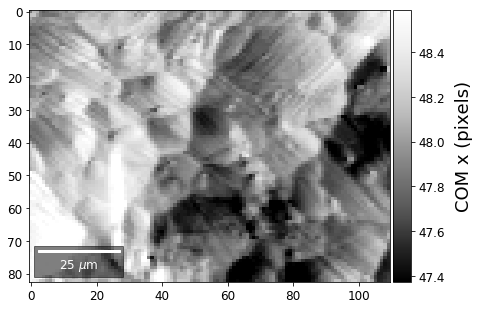

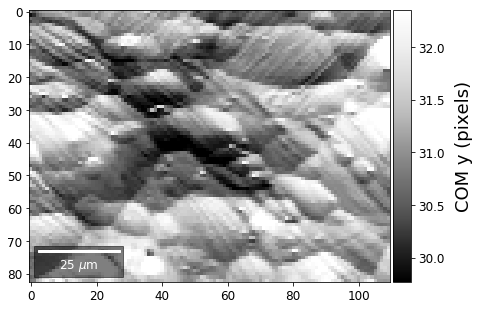

In [33]:
comx_map0=make2Dmap(COMxp[:],XIndex,YIndex,MapHeight,MapWidth)
comy_map0=make2Dmap(COMyp[:],XIndex,YIndex,MapHeight,MapWidth)

plot_SEM(comx_map0, colorbarlabel='COM x (pixels)', cmap='Greys_r')
plot_SEM(comy_map0, colorbarlabel='COM y (pixels)', cmap='Greys_r')

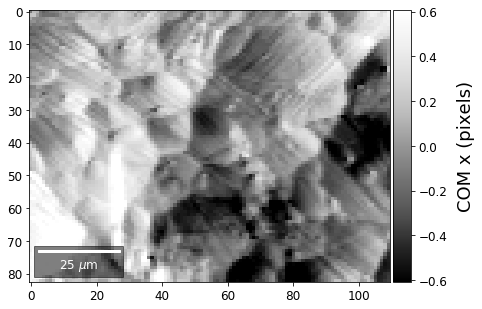

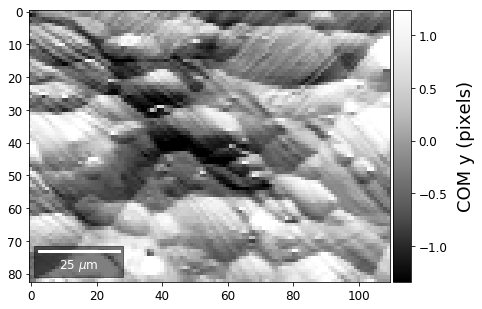

In [34]:
meanx=np.mean(COMxp)
meany=np.mean(COMyp)

comx_map=make2Dmap(COMxp[:]-meanx,XIndex,YIndex,MapHeight,MapWidth)
comy_map=make2Dmap(COMyp[:]-meany,XIndex,YIndex,MapHeight,MapWidth)

plot_SEM(comx_map, colorbarlabel='COM x (pixels)', filename='comx', cmap='Greys_r')
plot_SEM(comy_map, colorbarlabel='COM y (pixels)', filename='comy', cmap='Greys_r')

In [35]:
COMxp = h5f['/COM/COMxp_kiku']
COMyp = h5f['/COM/COMyp_kiku']

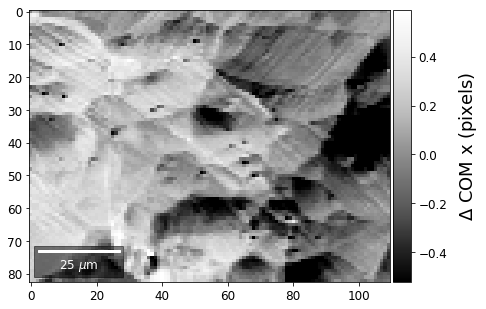

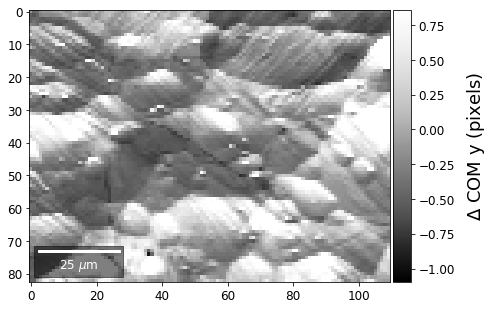

In [36]:
meanx = np.mean(COMxp)
meany = np.mean(COMyp)

comx_map = make2Dmap(COMxp[:] - meanx, XIndex, YIndex, MapHeight, MapWidth)
comy_map = make2Dmap(COMyp[:] - meany, XIndex, YIndex, MapHeight, MapWidth)

plot_SEM(comx_map, colorbarlabel='$\Delta$ COM x (pixels)', filename='comx', cmap='Greys_r')
plot_SEM(comy_map, colorbarlabel='$\Delta$ COM y (pixels)', filename='comy', cmap='Greys_r')

## Fourier Transform Based Imaging

With the help of the Fast Fourier Transform (FFT), we can extract information on spatial frequencies (wave vectors) from an image. This can be used to derive imaging signals which are based on ranges of specific wave vectors present in the Kikuchi pattern. 

In the example shown below, we determine the intensity in the four quadrants of the FFT spectrum magnitude. 
The points corresponding to the low spatial frequencies (large spatial extensions) are removed to suppress the influence of the background signal.

In [37]:
from scipy import fftpack

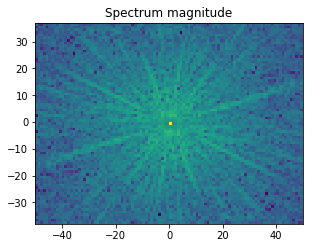

In [38]:
image = process_kikuchi(Patterns[0])
M, N = image.shape
F = fftpack.fftn(image)

F_magnitude = np.abs(F)
F_magnitude = fftpack.fftshift(F_magnitude)


magnitude = np.log(1 + F_magnitude)

f, ax = plt.subplots(figsize=(4.8, 4.8))

ax.imshow(magnitude, cmap='viridis',
          extent=(-N // 2, N // 2, -M // 2, M // 2))
ax.set_title('Spectrum magnitude');

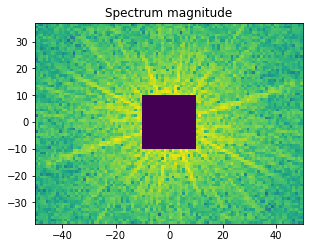

In [39]:
# Set block around center of spectrum to zero
K = 10
F_magnitude[M // 2 - K: M // 2 + K, N // 2 - K: N // 2 + K] = 0

magnitude = np.log(1 + F_magnitude)

f, ax = plt.subplots(figsize=(4.8, 4.8))

ax.imshow(magnitude, cmap='viridis',
          extent=(-N // 2, N // 2, -M // 2, M // 2))
ax.set_title('Spectrum magnitude');

In [40]:
W=20
Q1 = F_magnitude[M // 2    : M // 2 + W, N // 2    : N // 2 + W] 
Q2 = F_magnitude[M // 2    : M // 2 + W, N // 2 - W: N // 2    ] 
Q3 = F_magnitude[M // 2 - W: M // 2    , N // 2 - W: N // 2    ]
Q4 = F_magnitude[M // 2 - W: M // 2    , N // 2    : N // 2 + W]

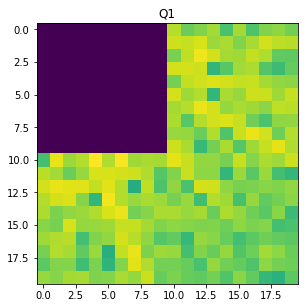

In [41]:
f, ax = plt.subplots(figsize=(4.8, 4.8))
ax.imshow(np.log(1 + Q1), cmap='viridis',)
ax.set_title('Q1');

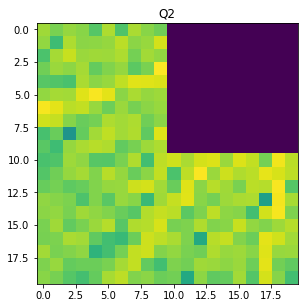

In [42]:
f, ax = plt.subplots(figsize=(4.8, 4.8))
ax.imshow(np.log(1 + Q2), cmap='viridis',)
ax.set_title('Q2');

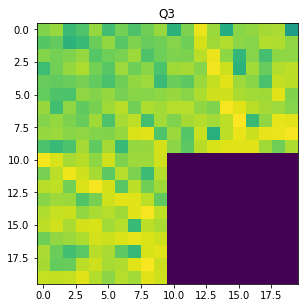

In [43]:
f, ax = plt.subplots(figsize=(4.8, 4.8))
ax.imshow(np.log(1 + Q3), cmap='viridis',)
ax.set_title('Q3');

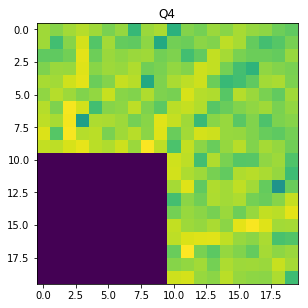

In [44]:
f, ax = plt.subplots(figsize=(4.8, 4.8))
ax.imshow(np.log(1 + Q4), cmap='viridis',)
ax.set_title('Q4');

In [45]:
def quadfft(image, K=5, W=20):
    """
    calculate FFT magnitude quadrants
    
    remove +/- K points in center (low spatial frequencies)
    limit to +/- W points away from center (low pass, avoid noise at higher frequencies)
    
    """
    M, N = image.shape
    F = fftpack.fftn(image)

    F_magnitude = np.abs(F)
    F_magnitude = fftpack.fftshift(F_magnitude)
    F_magnitude = np.log(1 + F_magnitude)
    
    # Set block +/-K around center of spectrum to zero
    F_magnitude[M // 2 - K: M // 2 + K, N // 2 - K: N // 2 + K] = 0

    Q1 = F_magnitude[M // 2    : M // 2 + W, N // 2    : N // 2 + W] 
    Q2 = F_magnitude[M // 2    : M // 2 + W, N // 2 - W: N // 2    ] 
    Q3 = F_magnitude[M // 2 - W: M // 2    , N // 2 - W: N // 2    ]
    Q4 = F_magnitude[M // 2 - W: M // 2    , N // 2    : N // 2 + W]
    
    SQ1 = np.sum(Q1)
    SQ2 = np.sum(Q2)
    SQ3 = np.sum(Q3)
    SQ4 = np.sum(Q4)
    
    return np.array([SQ1,SQ2,SQ3,SQ4])

In [46]:
def calc_quadfft(patterns, process=None, K=10, W=20):
    """
    calc magnitude sum in FFT quadrants of image
    "process" is an optional image pre-processing function
    """
    npatterns=patterns.shape[0]
    quad_fft_magnitude=np.zeros((npatterns, 4))
    tstart = time.time()
    for i in range(npatterns):
        # get current pattern
        if process is None:
            quad_fft_magnitude[i,:] = quadfft(patterns[i,:,:], K=K, W=W)
        else:
            quad_fft_magnitude[i,:] = quadfft(process(patterns[i,:,:]), K=K, W=W)

        # update time info every 10 patterns
        if (i % 100 == 0):
            progress=100.0*(i+1)/npatterns
            tup = time.time()
            togo = (100.0-progress)*(tup-tstart)/(60.0*progress)
            sys.stdout.write("\rtotal map points:%5i current:%5i progress: %4.2f%% -> %6.1f min to go" 
                % (npatterns,i+1,progress,togo)  )
            sys.stdout.flush()        

    return quad_fft_magnitude

In [47]:
qfftmag =  calc_quadfft(Patterns, process=process_kikuchi)

total map points: 9130 current: 9101 progress: 99.68% ->    0.0 min to go

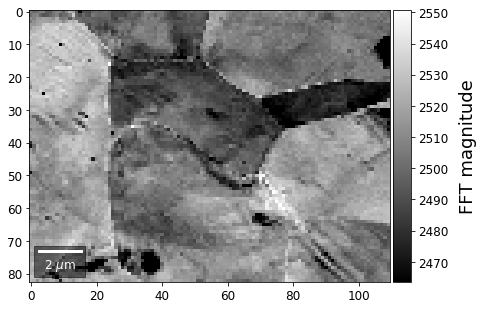

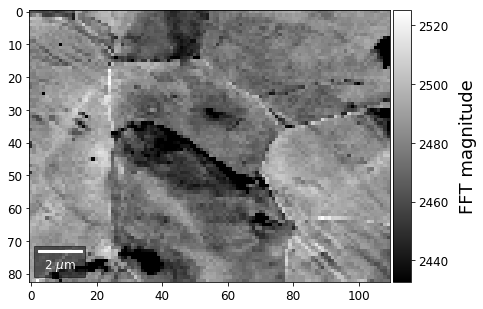

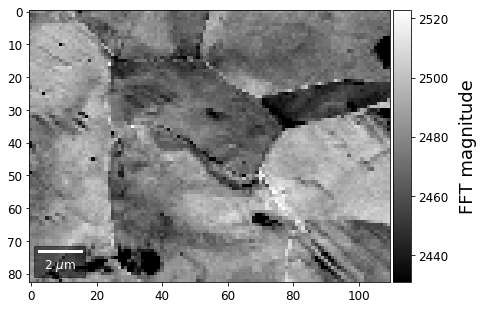

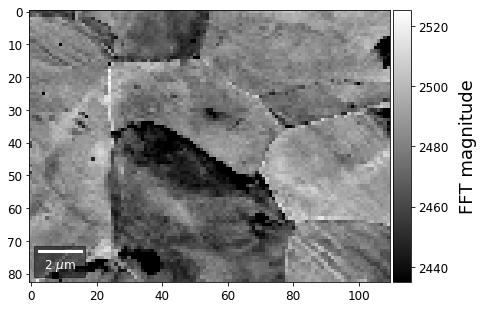

In [48]:
for q, quadrant in enumerate(qfftmag.T):
    signal_map = make2Dmap(quadrant,XIndex,YIndex,MapHeight,MapWidth)
    plot_SEM(signal_map, vrange=None, cmap='gray', 
             colorbarlabel='FFT magnitude', microns=step_map_microns,
             filename='qFFT_'+str(q))

In [49]:
signal = qfftmag[:,1] /qfftmag[:,0]
red = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

signal = qfftmag[:,2] /qfftmag[:,0]
green = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

signal = qfftmag[:,3] /qfftmag[:,0]
blue = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

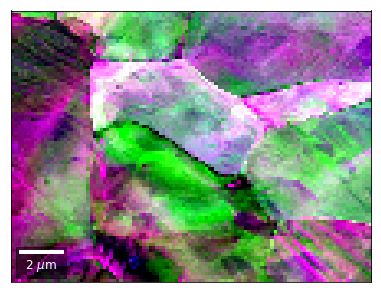

In [50]:
rgb=plot_SEM_RGB(red, green, blue, MapHeight, MapWidth, 
                     filename='qfft_RGB', microns=step_map_microns,
                     rot180=False, add_bright=0, contrast=1.0)

## Radon Transform Imaging

(...without pattern indexing ;-)

In [51]:
from skimage.transform import radon

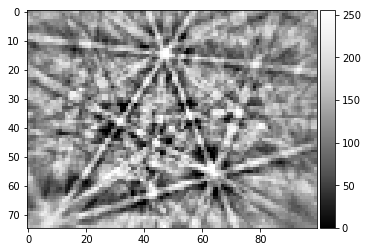

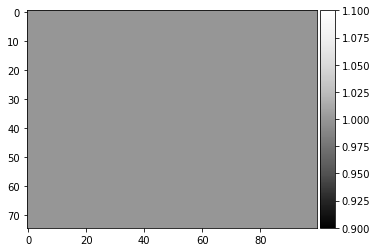

In [52]:
image = process_kikuchi(Patterns[0])
image_uniform = np.ones_like(image)

img_height, img_width = image.shape

plot_image(image)
plot_image(image_uniform)

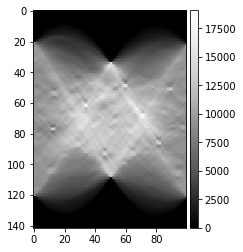

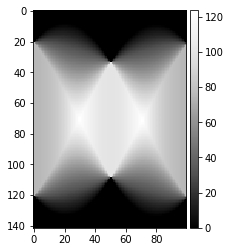

142 100 75
123.749473208


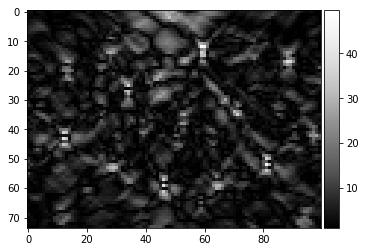

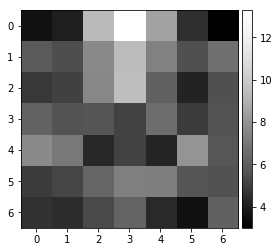

In [53]:
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=False)
sinogram_uniform = radon(image_uniform, theta=theta, circle=False)
plot_image(sinogram)
plot_image(sinogram_uniform)

sino = sinogram / sinogram_uniform
h,w = sino.shape
print(h,w, img_height)
sino_center = sino[h//2-img_height//2: h//2+img_height//2,:]

mean_radon = np.nanmean(sino_center)
print(mean_radon)
sino_center = np.sqrt(1.0+(sino_center - mean_radon)**2 )

sino77=arbse.rebin_array(sino_center)
plot_image(sino_center)
plot_image(sino77)

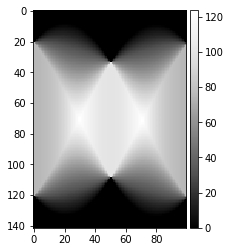

In [54]:
theta = np.linspace(0., 180., max(image.shape), endpoint=False)

image_uniform = np.ones_like(background_static_binned)
sinogram_uniform = radon(image_uniform, theta=theta, circle=False)

plot_image(sinogram_uniform)

def calc_radon(image, theta, sinogram_reference=None):
    """ calculate radon vbse array """
    
    sinogram = radon(image, theta=theta, circle=False)
    #if sinogram_reference is None:
    #    image_uniform = np.ones_like(image)
    #    sinogram_reference = radon(image_uniform, theta=theta, circle=False)

    img_height, img_width = image.shape

    sino = sinogram / sinogram_reference
    h,w = sino.shape

    sino_center = sino[h//2-img_height//2: h//2+img_height//2,:]
    mean_radon = np.nanmean(sino_center)
    sino_center = np.sqrt(1.0+(sino_center - mean_radon)**2 )
    return sino_center

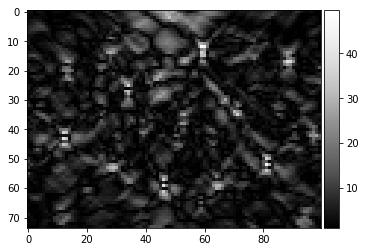

In [55]:
kiku = process_kikuchi(Patterns[0])
sino = calc_radon(kiku, theta, sinogram_reference=sinogram_uniform)
plot_image(sino)

def process_radon(pattern):
    kiku = process_kikuchi(pattern)
    sino = calc_radon(kiku, theta, sinogram_reference=sinogram_uniform)
    return sino

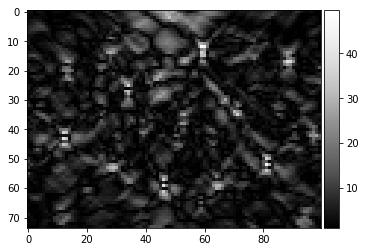

In [56]:
radon_test = process_radon(Patterns[0])
plot_image(radon_test)

In [57]:
vbse_radon =  arbse.make_vbse_array(Patterns, process=process_radon)

total points: 9130 current: 9130 finished -> total calculation time :   16.2 min 


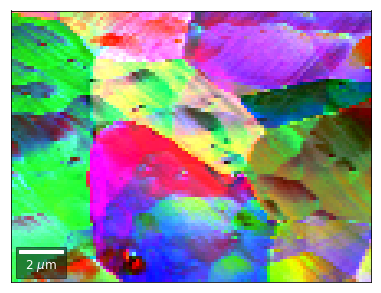

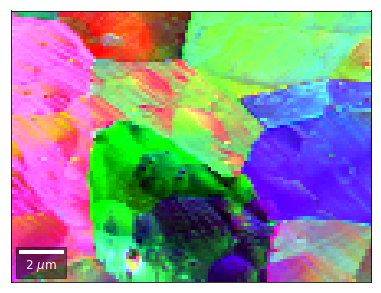

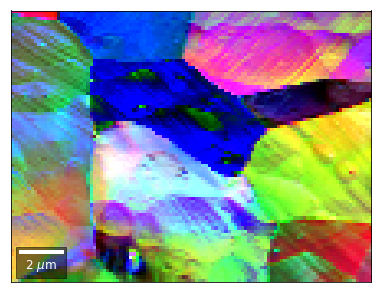

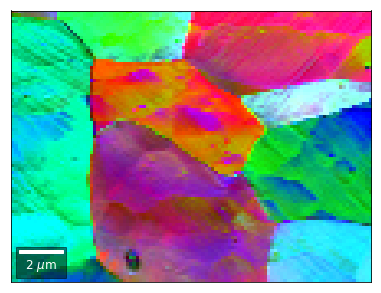

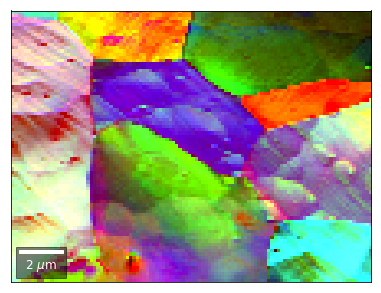

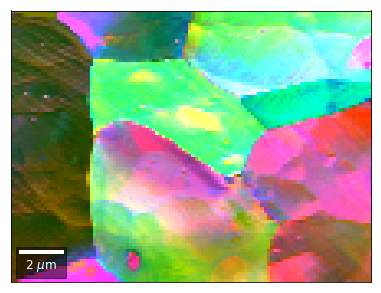

In [58]:
vFSD = vbse_radon
# relative change to previous row
for row in range(1,7):
    drow = -1
    signal = vFSD[:,row,0]/vFSD[:,row+drow,0]
    red = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    signal = vFSD[:,row,2]/vFSD[:,row+drow,2]
    green = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    signal = vFSD[:,row,4]/vFSD[:,row+drow,4]
    blue = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    rgb=plot_SEM_RGB(red, green, blue, MapHeight, MapWidth, 
                     filename='vRadon_RGB_drow_'+str(row),
                     microns=step_map_microns,
                     rot180=False, add_bright=0, contrast=1.2)

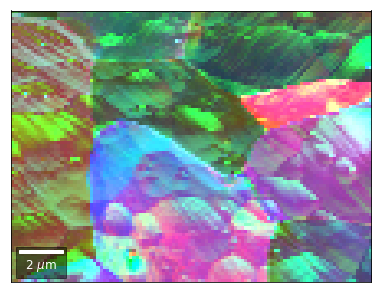

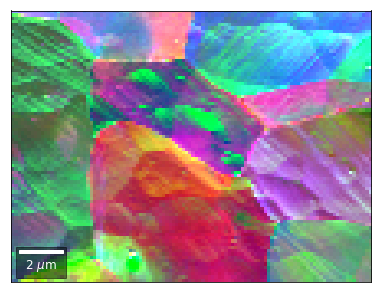

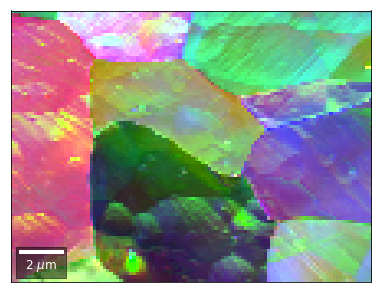

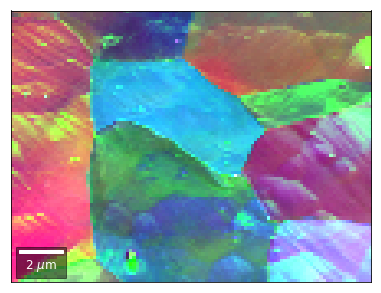

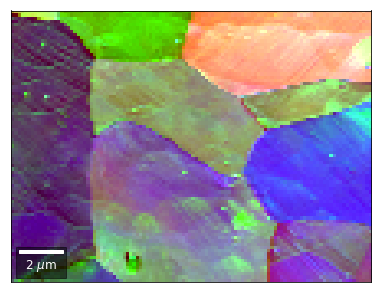

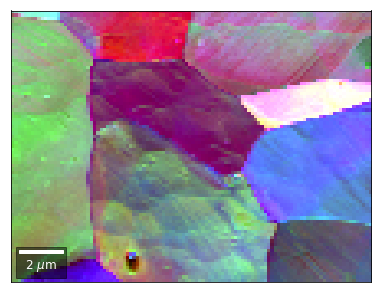

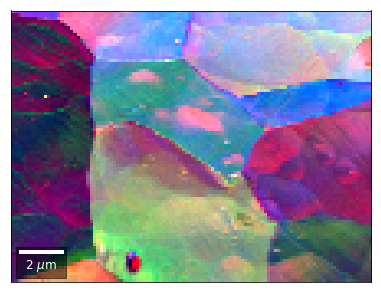

In [59]:
# rgb direct
rgb_direct = []

for row in range(7):
    signal = vFSD[:,row,0]
    red = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    signal = vFSD[:,row,3]
    green = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    signal = vFSD[:,row,6]
    blue = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)

    rgb=plot_SEM_RGB(red, green, blue, MapHeight, MapWidth, 
                     filename='vRadon_RGB_'+str(row),
                     rot180=False, microns=step_map_microns,
                     add_bright=0, contrast=0.8)
    
    rgb_direct.append(rgb)

Range of Values:  [24.123688464536887, 52.246895984591987]


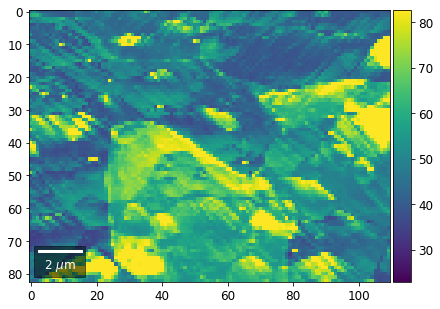

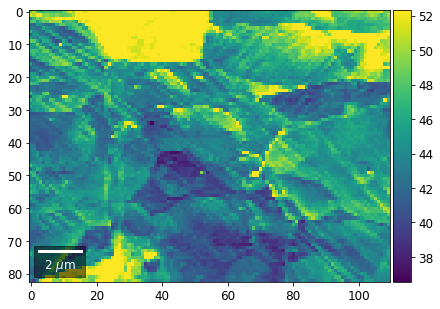

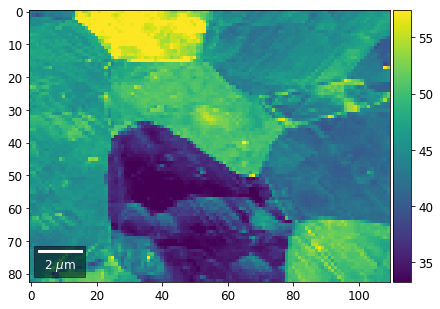

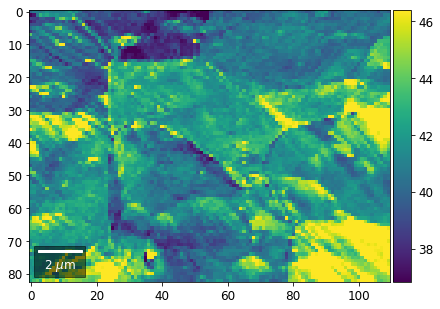

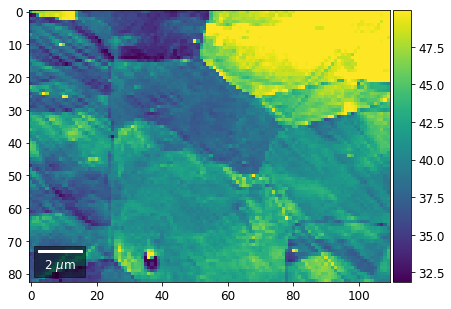

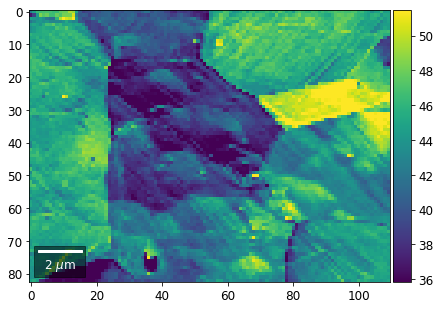

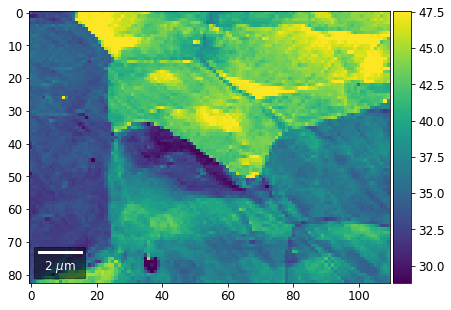

In [60]:
# signal: sum of row 
vmin=40000000
vmax=0

bse_rows = []

# (1) get full range for all images
for row in range(7):
    signal = np.sum(vFSD[:,row,:], axis=1) #/vFSD[:,row+drow,0]
    signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
    minv, maxv = get_vrange(signal, stretch=3.0)
    if (minv<vmin):
        vmin=minv
    if (maxv>vmax):
        vmax=maxv    

# (2) make plots with same range for comparisons of absolute BSE values
vrange=[minv, maxv]
print('Range of Values: ', vrange)
vrange=None
for row in range(7):
    signal = np.sum(vFSD[:,row,:], axis=1) #/vFSD[:,row+drow,0]
    signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
    bse_rows.append(signal_map)
    plot_SEM(signal_map, vrange=vrange, filename='vRadon_row_'+str(row),
             rot180=True, microns=step_map_microns)

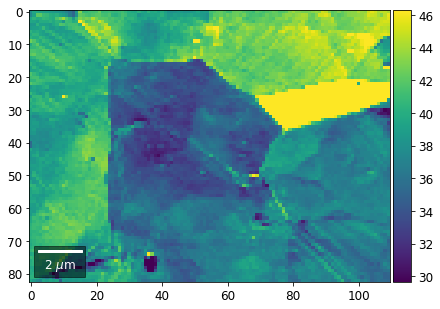

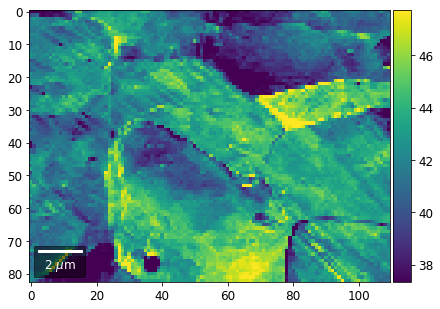

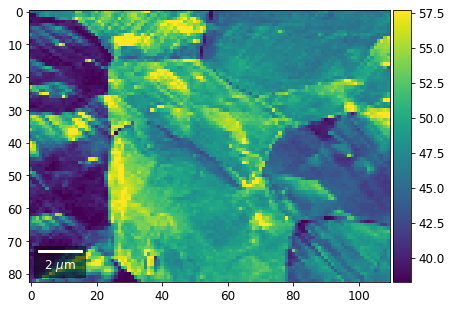

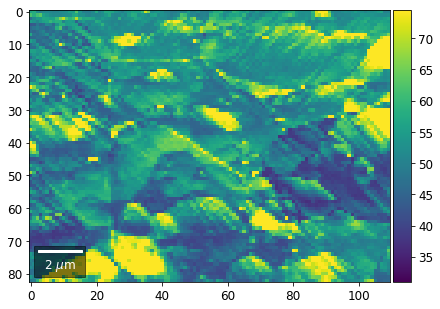

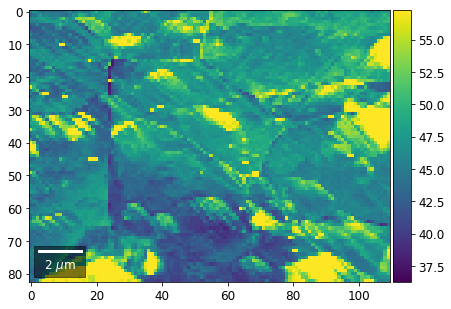

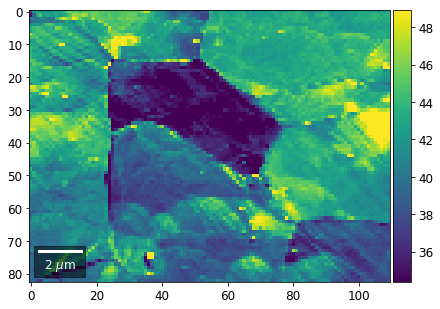

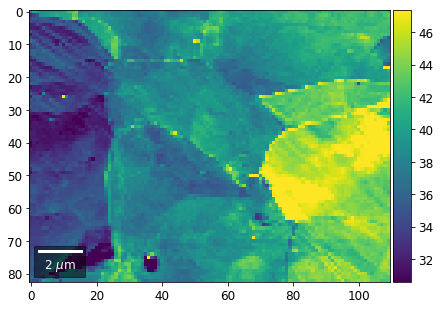

In [61]:
# signal: sum of column
vmin=400000
vmax=0

bse_cols = []

# (1) get full range for all images
for col in range(7):
    signal = np.sum(vFSD[:,:,col], axis=1) #/vFSD[:,row+drow,0]
    signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
    minv, maxv = get_vrange(signal)
    if (minv<vmin):
        vmin=minv
    if (maxv>vmax):
        vmax=maxv    

# (2) make plots with same range for comparisons of absolute BSE values
#vrange=[vmin, vmax]
vrange=None # no fixed scale

for col in range(7):
    signal = np.sum(vFSD[:,:,col], axis=1) #/vFSD[:,row+drow,0]
    signal_map = make2Dmap(signal,XIndex,YIndex,MapHeight,MapWidth)
    bse_cols.append(signal_map)
    plot_SEM(signal_map, vrange=vrange, filename='vRadon_col_'+str(col),
             rot180=True, microns=step_map_microns)